# Lab 8: Decision Trees
# Submitted by: Sarim Aeyzaz (i21-0328)

In [1]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
class DecisionTree:
    
    # Initialization
    def __init__(self, df, label):
        self.df = df
        self.label = label
        self.labelValues = df[label].unique()
        self.tree = {}
    
    
    
    # Entropy formula
    def entropy(self, df):
        length, entropy = len(df), 0

        # Iterates over Yes and No basically
        for l in self.labelValues: 

            # How many Yes's (or No's in second iteration)
            labelCount = len(df[df[self.label] == l])
            if labelCount == 0:
                continue
            entropy += -(labelCount/length) * np.log2(labelCount/length)
    
        return entropy
    
    
    
    # Information gain of a feature (column)
    def informationGain(self, featureName, df):
        featureValueList, totalLength, entropyCombined = df[featureName].unique(), len(df), 0

        # For each value of the feature, get its totalCount, its entropy and add it to entropyCombined variable
        for value in featureValueList:
            featureDf = df[df[featureName] == value]
            featureLength = len(featureDf)
            featureEntropy = self.entropy(featureDf)
            entropyCombined += featureLength/totalLength * featureEntropy

        return self.entropy(df) - entropyCombined # Info gain
    
    
    
    # Selecting best feature based on current dataframe entered
    def bestFeature(self, df):
    
        featureList = df.columns.drop(self.label) # Removing label column
        allInfoGains = [(self.informationGain(feature, df), feature) for feature in featureList]
        maximumInfoGain, maximumFeature = max(allInfoGains, key = lambda x:x[0])

        return maximumFeature
    
    
    
    # Creating subtree for a feature (used in makeTree function)
    def createSubTree(self, featureName, df):
        featureValuesAndCounts, tree = df[featureName].value_counts(), {}

        # For every value in the feature, create its filtered dataframe
        for value, count in featureValuesAndCounts.iteritems():
            featureDf, assigned = df[df[featureName] == value], False

            # Iterate over yes and no for each value
            for l in self.labelValues:

                # If labelCount == count, this would indicate a pure class, assign it in the tree
                # and remove dataframe rows which represent this pure class
                labelCount = len(featureDf[featureDf[self.label] == l])
                if labelCount == count:
                    tree[value] = l
                    df = df[df[featureName] != value] # Important: Removing rows feature's value
                    assigned = True

            # Otherwise, the value is still an impure and can be expanded further, mark it as "?" for the makeTree
            # function to check later
            if not assigned:
                tree[value] = "?"

        return tree, df
    
    
    
    # Making the tree :D. Recursion of the tree will end when dataset is empty or no more branches can be expanded
    def makeTree(self, root, previousValue, df):

        # One of the base cases
        if len(df) != 0: 

            # Get best feature and generate its tree
            featureName = self.bestFeature(df)
            tree, df = self.createSubTree(featureName, df)

            # If this is a previous value, extend the tree from that value onwards
            if previousValue != None:
                root[previousValue] = dict()
                root[previousValue][featureName] = tree
                nextRoot = root[previousValue][featureName]

            # Otherwise, start from the root node
            else:
                root[featureName] = tree
                nextRoot = root[featureName]

            # For every value in the tree that can be expanded further, run the recusrive makeTree function
            for value, branch in nextRoot.items(): 
                if branch == "?":
                    featureDf = df[df[featureName] == value]
                    self.makeTree(nextRoot, value, featureDf)

                    
                    
    # Standard Fit function
    def fit(self):
        self.makeTree(self.tree, None, df)
        
        
        
    def printTree(self):
        print(self.tree)
        
        
        
    # Standard predict function (give row as input)
    def predict(self, tree, row):
        # Return if it's a leaf node
        if not isinstance(tree, dict):
            return tree
        else:
            # Get the feature name from tree and the its value from the row
            label = next(iter(tree))
            value = row[label]

            # If the value exists in the tree, do a recursive search till base case and get either a yes or no at the end
            if value in tree[label]:
                return self.predict(tree[label][value], row)
            else:
                return None
          
        
        
    # Computing Accuracy of Decision Tree
    def evaluate(self):
        predictedValues = [self.predict(self.tree, self.df.iloc[index]) for index, row in self.df.iterrows()]
        truth = self.df[self.label]
        print(classification_report(truth, predictedValues))
        matrix = confusion_matrix(truth, predictedValues)
        graphMatrix = ConfusionMatrixDisplay(confusion_matrix = matrix)
        graphMatrix.plot()
        plt.show()

In [3]:
df = pd.read_csv("PlayTennis.csv")
df.head()

,Outlook,Temperature,Humidity,Wind,Play Tennis
0,Sunny,Hot,High,Weak,No
1,Sunny,Hot,High,Strong,No
2,Overcast,Hot,High,Weak,Yes
3,Rain,Mild,High,Weak,Yes
4,Rain,Cool,Normal,Weak,Yes


In [4]:
model = DecisionTree(df, 'Play Tennis')

In [5]:
model.fit()

In [6]:
model.printTree()

{'Outlook': {'Sunny': {'Humidity': {'High': 'No', 'Normal': 'Yes'}}, 'Rain': {'Wind': {'Weak': 'Yes', 'Strong': 'No'}}, 'Overcast': 'Yes'}}


In [7]:
# Output in more pretty form :D

{
    'Outlook': {
        'Sunny': {
            'Humidity': {
                'High': 'No', 
                'Normal': 'Yes'
            }
        },
        'Overcast': 'Yes',
        'Rain': {
            'Wind': {
                'Weak': 'Yes', 
                'Strong': 'No'
            }
        }
    }
}

{'Outlook': {'Sunny': {'Humidity': {'High': 'No', 'Normal': 'Yes'}},
  'Overcast': 'Yes',
  'Rain': {'Wind': {'Weak': 'Yes', 'Strong': 'No'}}}}

              precision    recall  f1-score   support

          No       1.00      1.00      1.00         5
         Yes       1.00      1.00      1.00         9

    accuracy                           1.00        14
   macro avg       1.00      1.00      1.00        14
weighted avg       1.00      1.00      1.00        14



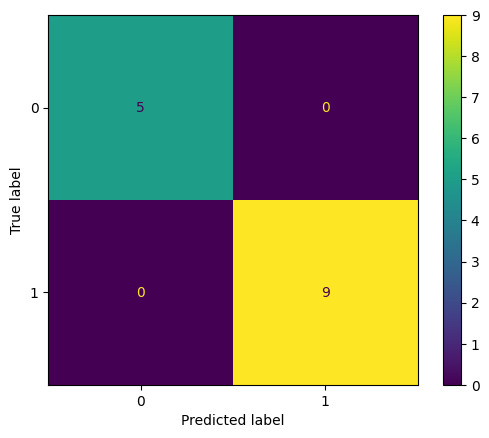

In [8]:
model.evaluate()